In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

START = 2018
END = 2025

In [2]:
# RAG+LLM 추출 내용 load
def get_extracted_data(start : int = START, end : int = END):
    papers = {}
    models = {}
    metrics = {}

    for i in range(start, end+1):
        papers[f"{i}"] = pd.read_csv(f"./res/{i}/papers.csv")
        models[f"{i}"] = pd.read_csv(f"./res/{i}/models.csv")
        metrics[f"{i}"] = pd.read_csv(f"./res/{i}/metrics.csv")

    return papers, models, metrics

# 메타데이터 불러오는 헬퍼 함수
def get_metadata(start : int = START, end : int = END) -> dict[str, pd.DataFrame]:
    metadatas = {}

    for i in range(start, end+1):
        root = f"./res/{i}/metadata"
        metadatas[f"{i}"] = pd.concat(
            [
                pd.read_csv(os.path.join(root, file_name)).assign(keyword=file_name[:-4])
                for file_name in os.listdir(root)
                if file_name.endswith(".csv")
            ],
            axis=0,
            ignore_index=True
        )
        metadatas[f"{i}"] = metadatas[f"{i}"].dropna(subset=["Document Title"])
        metadatas[f"{i}"]["Abstract"] = metadatas[f"{i}"]["Abstract"].astype(str)
        
    return metadatas


metadatas = get_metadata()
papers, models, metrics = get_extracted_data()


# 파라미터 증가 추이 확인

In [3]:
parameter_counts = []
for i in range(START, END+1):
    parameter_counts.append(models[str(i)].parameter_count)

anual_param_count = pd.concat(parameter_counts, axis=1)
anual_param_count.columns = [str(i) for i in range(START, END+1)]


In [4]:
def remove_outliers_iqr(df: pd.DataFrame) -> pd.DataFrame:
    df_filtered = df.copy()

    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        df_filtered[col] = df[col].where(
            (df[col] >= lower) & (df[col] <= upper)
        )

    return df_filtered

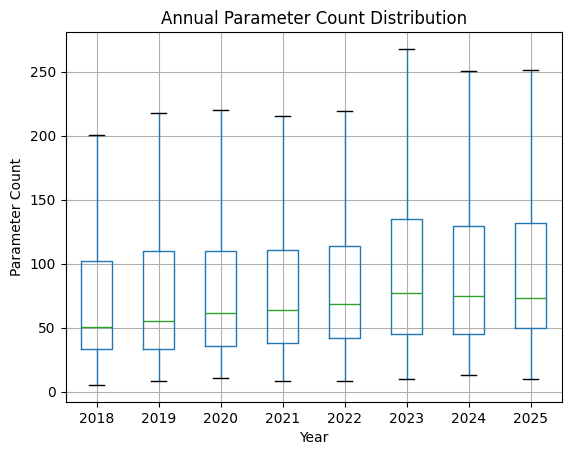

In [5]:
anual_filtered = remove_outliers_iqr(anual_param_count)

anual_filtered.boxplot(showfliers=False)
plt.xlabel("Year")
plt.ylabel("Parameter Count")
plt.title("Annual Parameter Count Distribution")
plt.show()

# 시간대별, task별 모델 파라미터 수 변화 추이

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def visualize_task_trends(models, k=5, normalize=True, use_log=False, exclude_tasks=['Other']):
    """
    Task별 모델 파라미터 수의 추이를 시각화하는 함수
    이 때 스케일링은 task별 전체 년도에 대해서 적용
    
    Args:
        models (dict): {year: dataframe} 형태의 데이터
        k (int): 상위 몇 개의 Task를 보여줄 것인지 설정
        normalize (bool): Min-Max 정규화 수행 여부
        use_log (bool): Y축 로그 스케일 적용 여부
        exclude_tasks (list): 제외할 Task 리스트
    """
    
    def preprocess_data(models_dict):
        df_list = []
        for year, df in models_dict.items():
            temp_df = df.copy()
            temp_df['year'] = int(year)
            df_list.append(temp_df)
        
        combined_df = pd.concat(df_list, ignore_index=True)

        for task in exclude_tasks:
            combined_df = combined_df[combined_df['task'] != task]
        return combined_df

    def filter_top_tasks(df, top_k):
        top_tasks = df['task'].value_counts().nlargest(top_k).index
        return df[df['task'].isin(top_tasks)].copy()

    def apply_normalization(df):
        def normalize_group(group):
            min_val = group.min()
            max_val = group.max()
            if max_val - min_val == 0:
                return 0.5
            return (group - min_val) / (max_val - min_val)
        
        df['target_value'] = df.groupby('task')['parameter_count'].transform(normalize_group)
        return df

    total_df = preprocess_data(models)
    filtered_df = filter_top_tasks(total_df, k)
    
    y_label = 'Parameter Count'
    title_suffix = f'(Top {k} Tasks Average)'
    
    if normalize:
        filtered_df = apply_normalization(filtered_df)
        y_col = 'target_value'
        y_label = 'Normalized Scale (0 to 1)'
        title_prefix = 'Normalized'
    else:
        filtered_df['target_value'] = filtered_df['parameter_count']
        y_col = 'target_value'
        title_prefix = 'Raw'

    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")
    
    sns.lineplot(
        data=filtered_df, 
        x='year', 
        y=y_col, 
        hue='task', 
        marker='o', 
        linewidth=2.5,
        errorbar=None
    )

    if use_log and not normalize: # 정규화된 데이터에 로그를 거는 것은 보통 의미가 없으므로 체크
        plt.yscale("log")
        y_label += ' (Log Scale)'
    
    plt.title(f'{title_prefix} Parameter Count Trend: {title_suffix}', fontsize=16, pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    
    plt.xticks(sorted(filtered_df['year'].unique()))
    plt.legend(title='Top Tasks', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    plt.show()

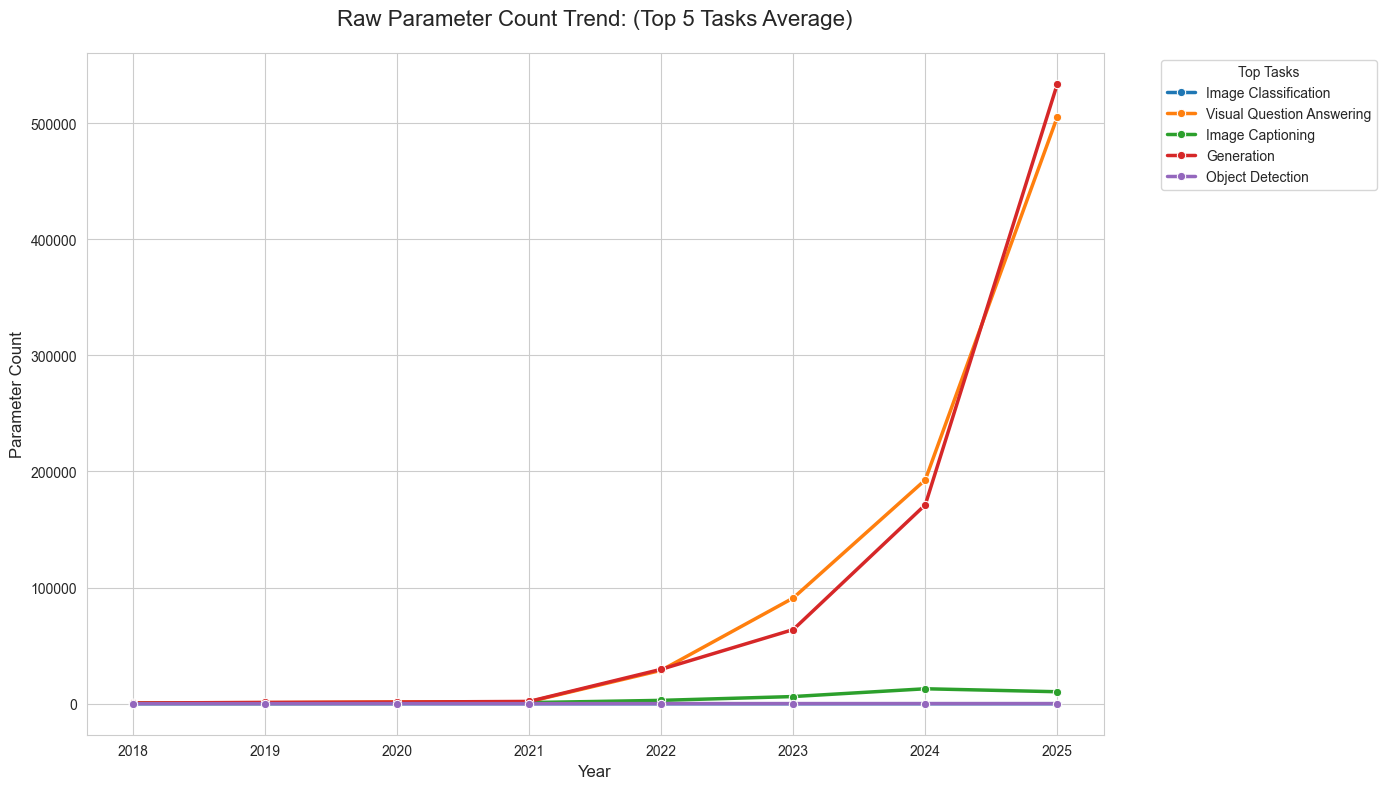

In [7]:
visualize_task_trends(models, k=5, normalize=False, use_log=False)

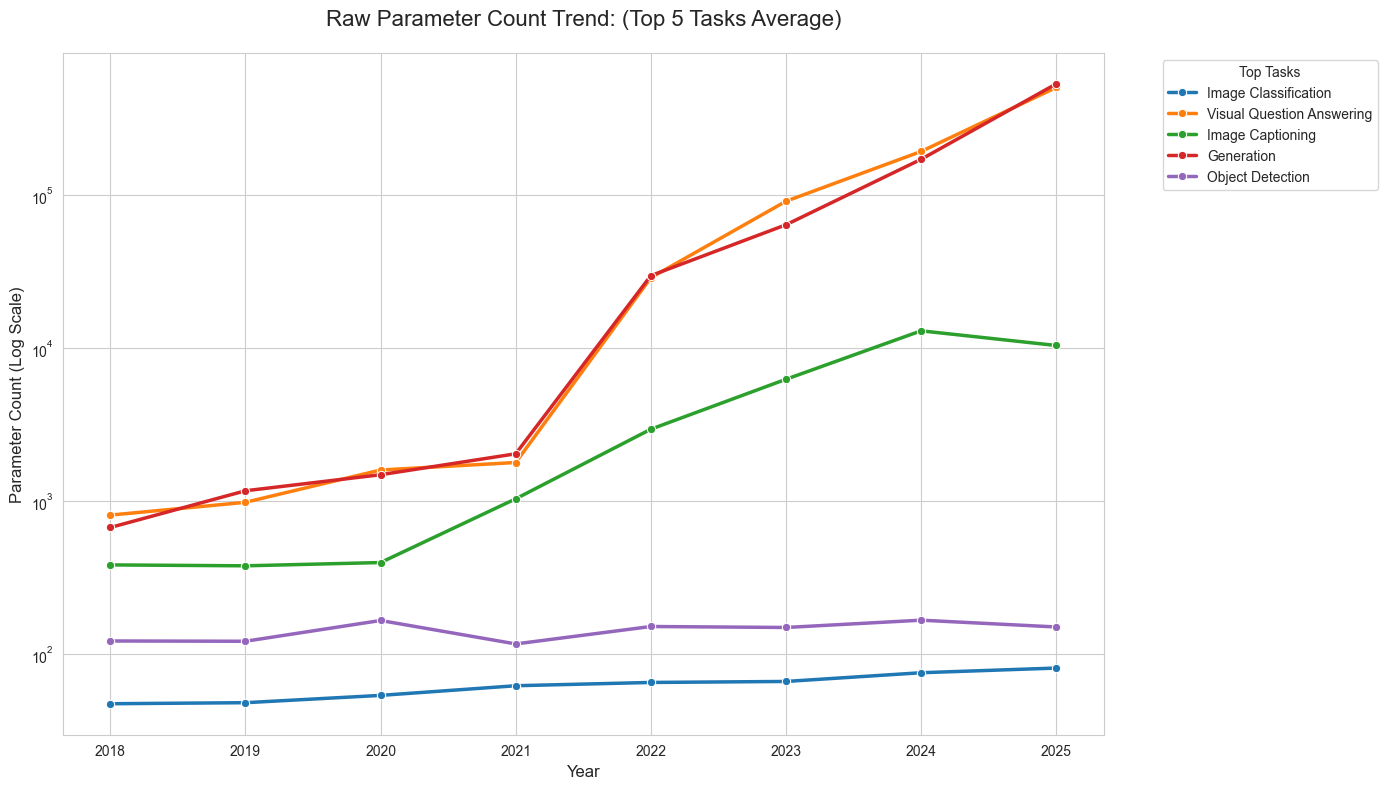

In [8]:
visualize_task_trends(models, k=5, normalize=False, use_log=True)

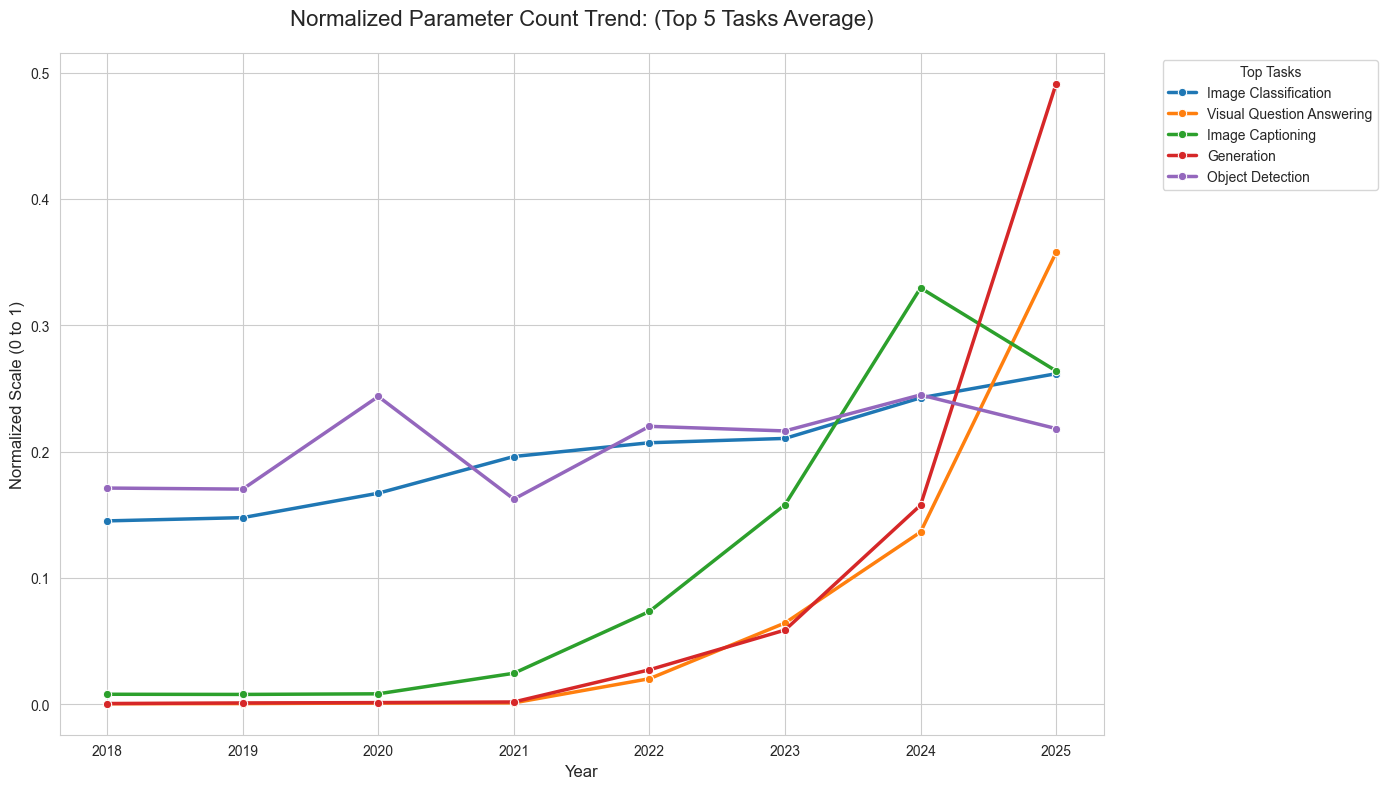

In [9]:
visualize_task_trends(models, k=5, normalize=True, use_log=False)

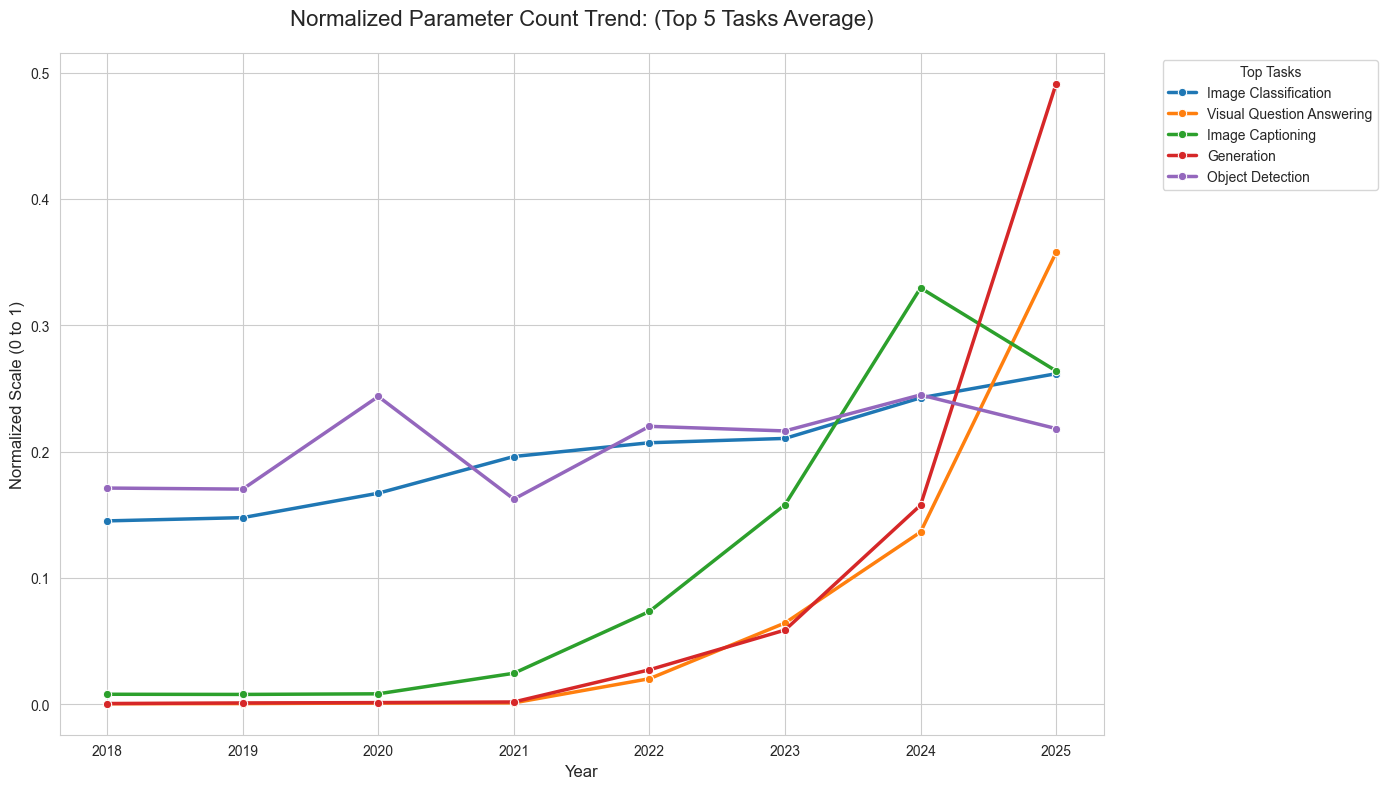

In [10]:
visualize_task_trends(models, k=5, normalize=True, use_log=True)

In [ ]:
def visualize_task_boxplots(models, k=5, normalize=False, use_log=False, exclude_tasks=['Other']):
    """
    Task별 모델 파라미터 수의 분포를 년도별 Boxplot으로 시각화하는 함수
    
    Args:
        models (dict): {year: dataframe} 형태의 데이터
        k (int): 상위 몇 개의 Task를 보여줄 것인지 설정
        normalize (bool): Min-Max 정규화 수행 여부
        use_log (bool): Y축 로그 스케일 적용 여부
        exclude_tasks (list): 제외할 Task 리스트
    """
    
    def preprocess_data(models_dict):
        df_list = []
        for year, df in models_dict.items():
            temp_df = df.copy()
            temp_df['year'] = int(year)
            df_list.append(temp_df)
        
        combined_df = pd.concat(df_list, ignore_index=True)
        for task in exclude_tasks:
            combined_df = combined_df[combined_df['task'] != task]
        return combined_df

    def filter_top_tasks(df, top_k):
        top_tasks = df['task'].value_counts().nlargest(top_k).index
        return df[df['task'].isin(top_tasks)].copy()

    def apply_normalization(df):
        def normalize_group(group):
            min_val = group.min()
            max_val = group.max()
            if max_val - min_val == 0: return 0.5
            return (group - min_val) / (max_val - min_val)
        df['target_value'] = df.groupby('task')['parameter_count'].transform(normalize_group)
        return df

    total_df = preprocess_data(models)
    filtered_df = filter_top_tasks(total_df, k)
    
    y_label = 'Parameter Count'
    title_suffix = f'(Top {k} Tasks)'
    
    if normalize:
        filtered_df = apply_normalization(filtered_df)
        y_col = 'target_value'
        y_label = 'Normalized Scale (0 to 1)'
        title_prefix = 'Normalized'
    else:
        filtered_df['target_value'] = filtered_df['parameter_count']
        y_col = 'target_value'
        title_prefix = 'Raw'

    plt.figure(figsize=(15, 8))
    sns.set_style("whitegrid")
    
    sns.boxplot(
        data=filtered_df, 
        x='year', 
        y=y_col, 
        hue='task', 
        showfliers=False,  # 이상치(fliers) 숨기기 요청 반영
        palette='viridis'  # 시각적 구분을 위한 색상 팔레트
    )

    if use_log and not normalize:
        plt.yscale("log")
        y_label += ' (Log Scale)'
    
    plt.title(f'{title_prefix} Parameter Distribution by Task: {title_suffix}', fontsize=16, pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    
    plt.legend(title='Tasks', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    plt.show()

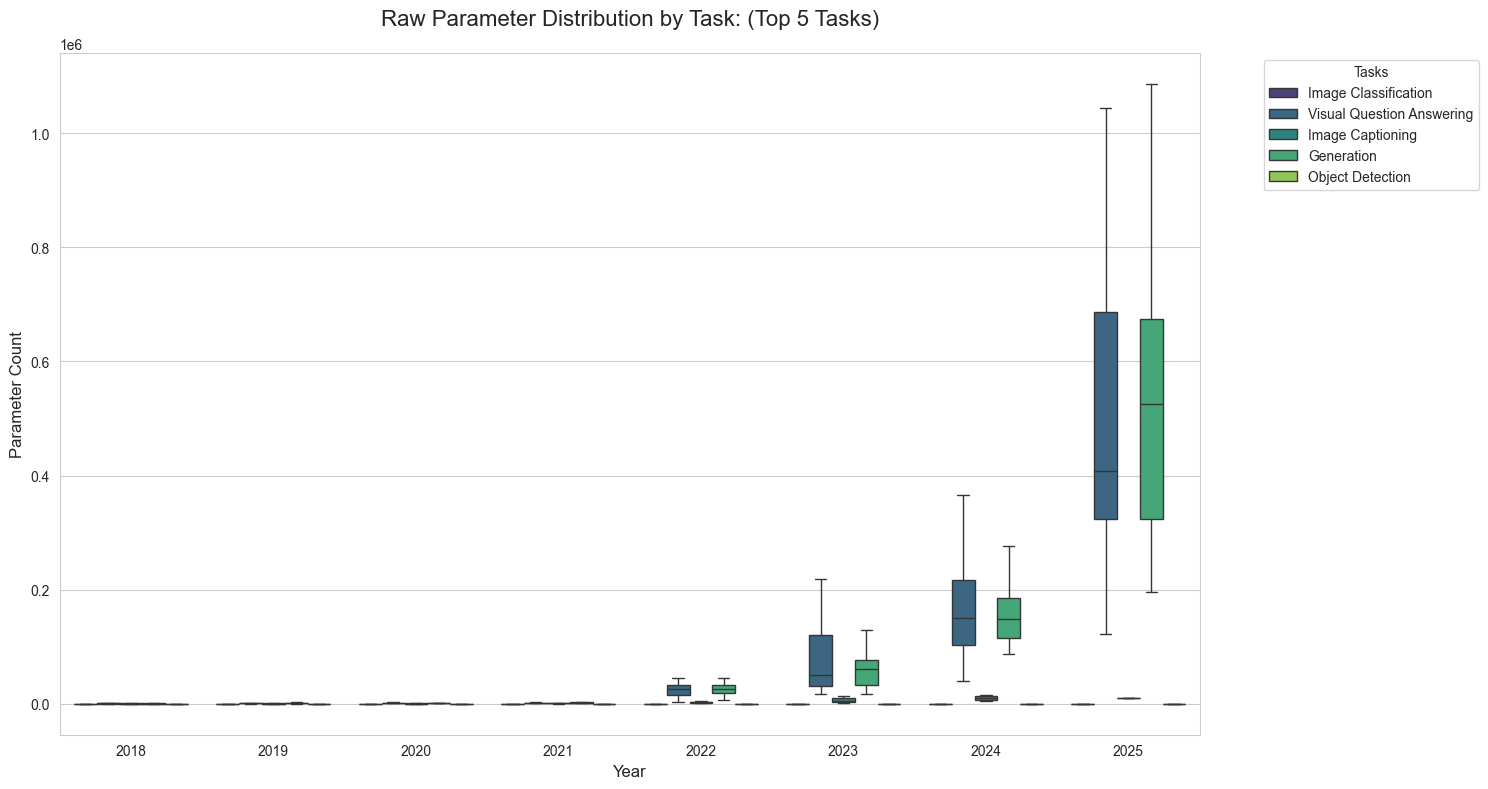

In [12]:
visualize_task_boxplots(models, k=5, normalize=False, use_log=False)

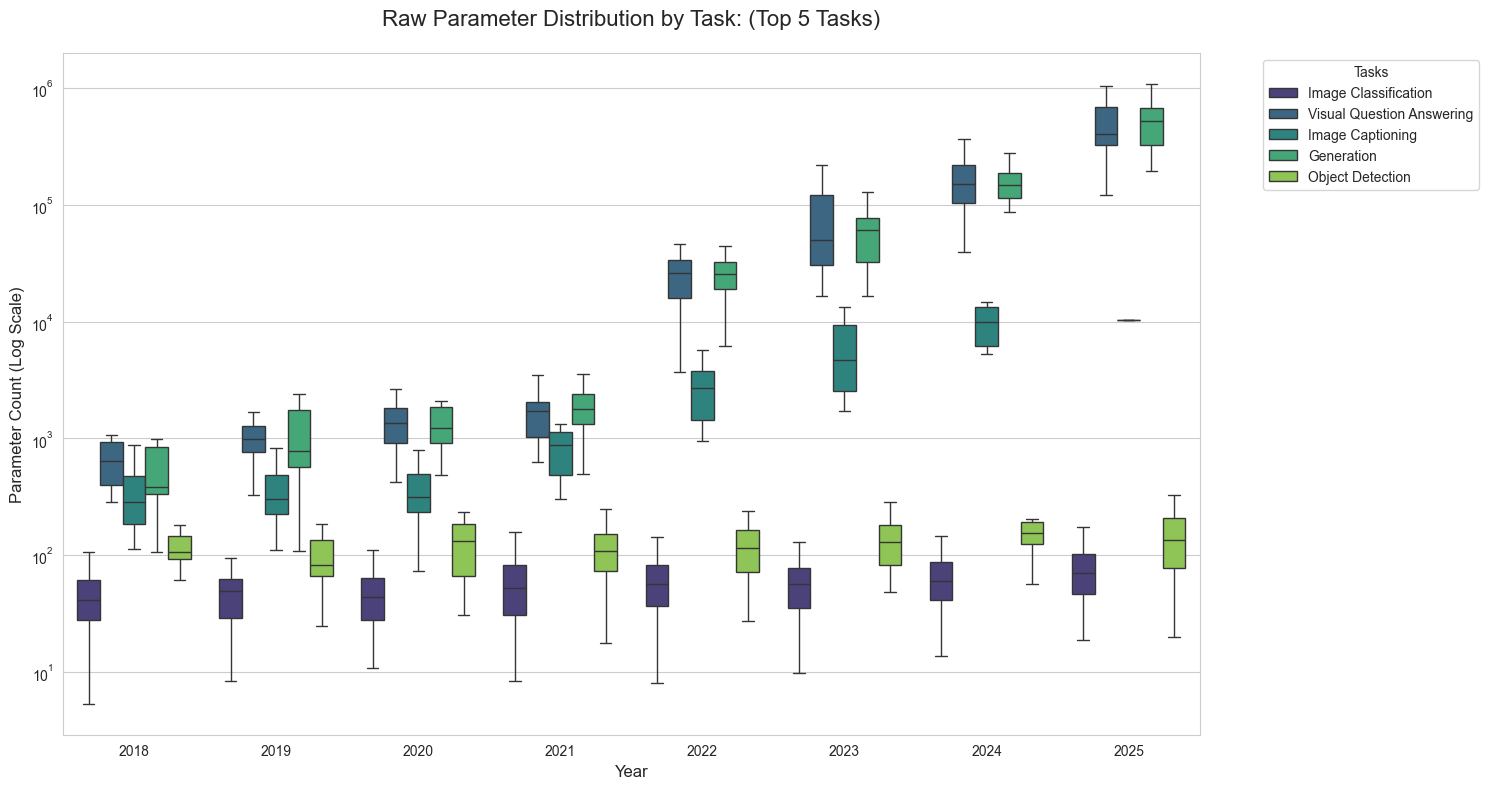

In [13]:
visualize_task_boxplots(models, k=5, normalize=False, use_log=True)